# Feature Selection and Engineering

##### *In which we boost, combine, split, or otherwise manipulate the features of crabs.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/2-features)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/2-features/features.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


### Define Constants


In [1]:
%%time
CACHE_FILE = '../cache/splitcrabs.feather'
NEXT_CACHE_FILE = '../cache/designrcrabs.feather'
NEXT_NOTEBOOK = '../3-evaluation/evaluation.ipynb'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries


In [2]:
%%time
from notebooks.time_for_crab.mlutils import display_df

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


CPU times: total: 0 ns
Wall time: 102 ms


### Load Data from Cache

In the [previous section](../1-models/models.ipynb), we saved the normalized training data to the cache.


In [3]:
%%time
crabs = pd.read_feather(CACHE_FILE)
crabs_test = pd.read_feather(CACHE_FILE.replace('.feather', '_test.feather'))

display_df(crabs, show_distinct=True)

# split features from target
X_train = crabs.drop([PREDICTION_TARGET], axis=1)
y_train = crabs[PREDICTION_TARGET]

X_test = crabs_test.drop([PREDICTION_TARGET], axis=1)
y_test = crabs_test[PREDICTION_TARGET]


DataFrame shape: (3031, 11)
First 5 rows:
        Length  Diameter    Height    Weight  Shucked Weight  Viscera Weight  \
3483  1.724609  1.312500  0.500000  50.53125       25.984375        9.429688   
993   1.612305  1.312500  0.500000  41.09375       17.031250        7.273438   
1427  1.650391  1.262695  0.475098  40.78125       19.203125        8.078125   
3829  1.362305  1.150391  0.399902  25.43750        9.664062        4.691406   
1468  1.250000  0.924805  0.375000  30.09375       14.007812        6.320312   

      Shell Weight  Sex_F  Sex_I  Sex_M  Age  
3483     13.070312  False  False   True   12  
993      14.320312   True  False  False   13  
1427      5.046875  False  False   True   11  
3829      9.781250  False  False   True   10  
1468      8.390625  False  False   True    9  
<class 'pandas.core.frame.DataFrame'>
Index: 3031 entries, 3483 to 658
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 

## Data Normalization

Crabs come in all shapes and sizes. Let's normalize the data to help our model make better sense of it.

![Tiny crab](https://www.popsci.com/uploads/2022/02/09/fiddler-crab.jpg?auto=webp&optimize=high&width=1440)

The book *Designing Machine Learning Systems* (Huyen, 2022) suggests normalizing to a range of [-1, 1] helps in practice.

Data normalization can help avoid data leakage based on the "form" of the data.


In [4]:
%%time
def data_normalization(df:pd.DataFrame, a:float=-1., b:float=1., df_min:pd.Series=None,  df_max:pd.Series=None) -> pd.DataFrame:
    """Normalize the DataFrame from a to b.
    
    :param df: The data.
    :param a: The minimum value.
    :param b: The maximum value.
    :param df_min: The minimum value of the data.
    :param df_max: The maximum value of the data.
    :return: The normalized data.
    """
    # scale the data to a range of [a, b]
    df_min = df.min() if df_min is None else df_min
    df_max = df.max() if df_max is None else df_max
    df = a + ((df - df_min) * (b - a)) / (df_max - df_min)
    return df


CPU times: total: 0 ns
Wall time: 0 ns


#### Show Distributions Before Normalization


CPU times: total: 125 ms
Wall time: 180 ms


Text(0.5, 1.0, 'Before Normalization')

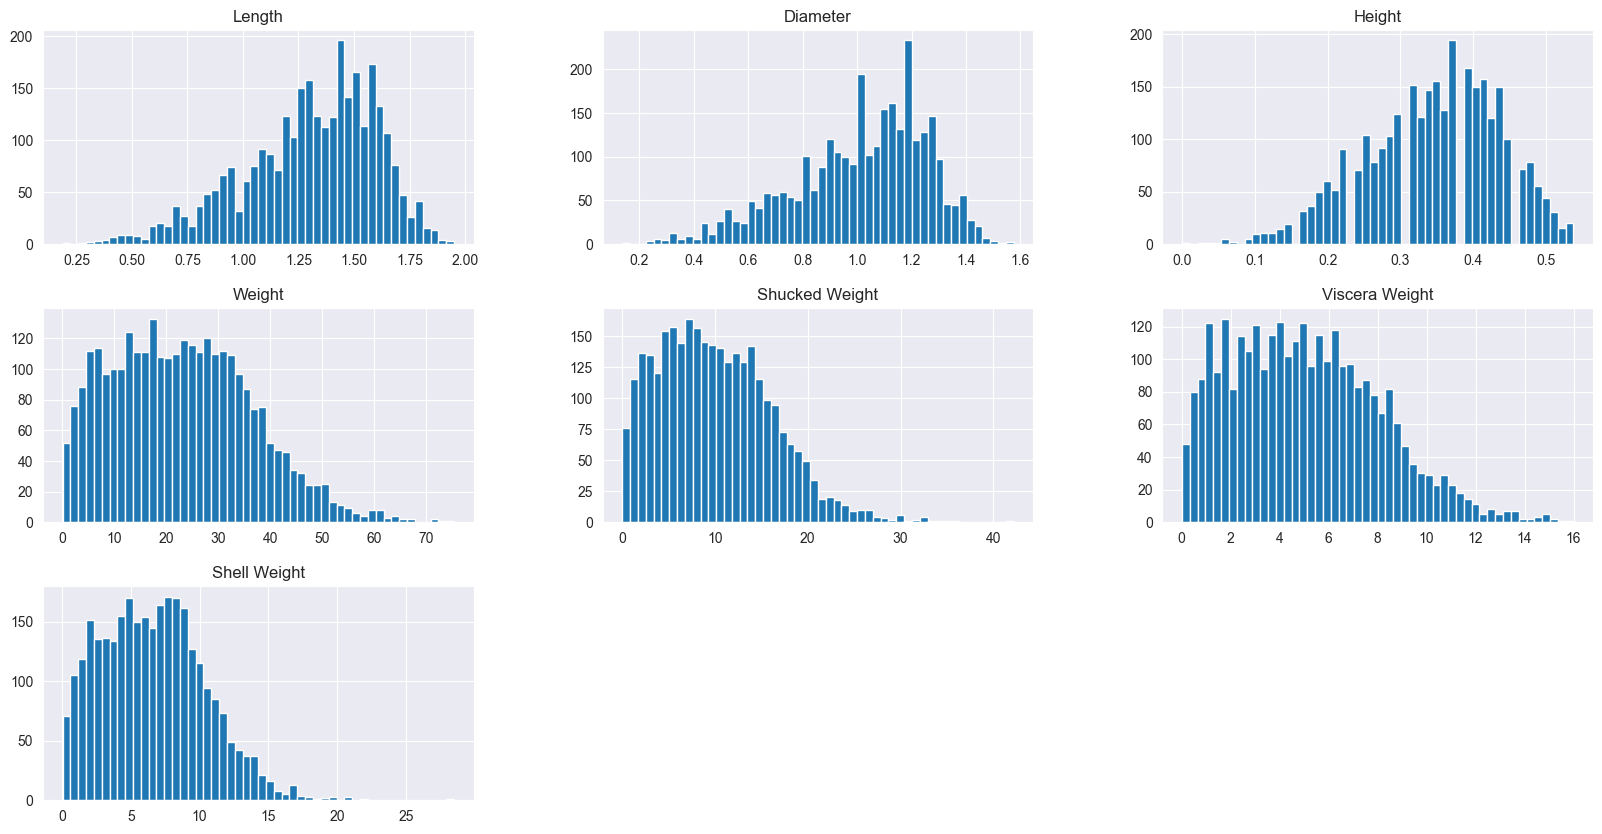

In [5]:
%%time
X_train.hist(figsize=(20, 10), bins=50)
plt.title('Before Normalization')


#### Normalize the Data
 
Ensure we're only normalizing using parameters from the training data to prevent data leakage.  


In [6]:
%%time
# normalize the data
for col in X_train.select_dtypes(include=[np.number]).columns:
    X_train[col] = data_normalization(X_train[col], df_min=X_train[col].min(), df_max=X_train[col].max())
X_train.describe().transpose()[['mean','std']]


CPU times: total: 0 ns
Wall time: 11 ms


,mean,std
Length,0.265869,0.337646
Diameter,0.217896,0.341553
Height,0.281738,0.345459
Weight,-0.390137,0.356934
Shucked Weight,-0.525879,0.289795
Viscera Weight,-0.372803,0.377197
Shell Weight,-0.538086,0.264404


#### Show Distributions After Normalization

Shape of the distribution should remain nearly the same, but the range should be [-1, 1].


CPU times: total: 125 ms
Wall time: 173 ms


Text(0.5, 1.0, 'After Normalization')

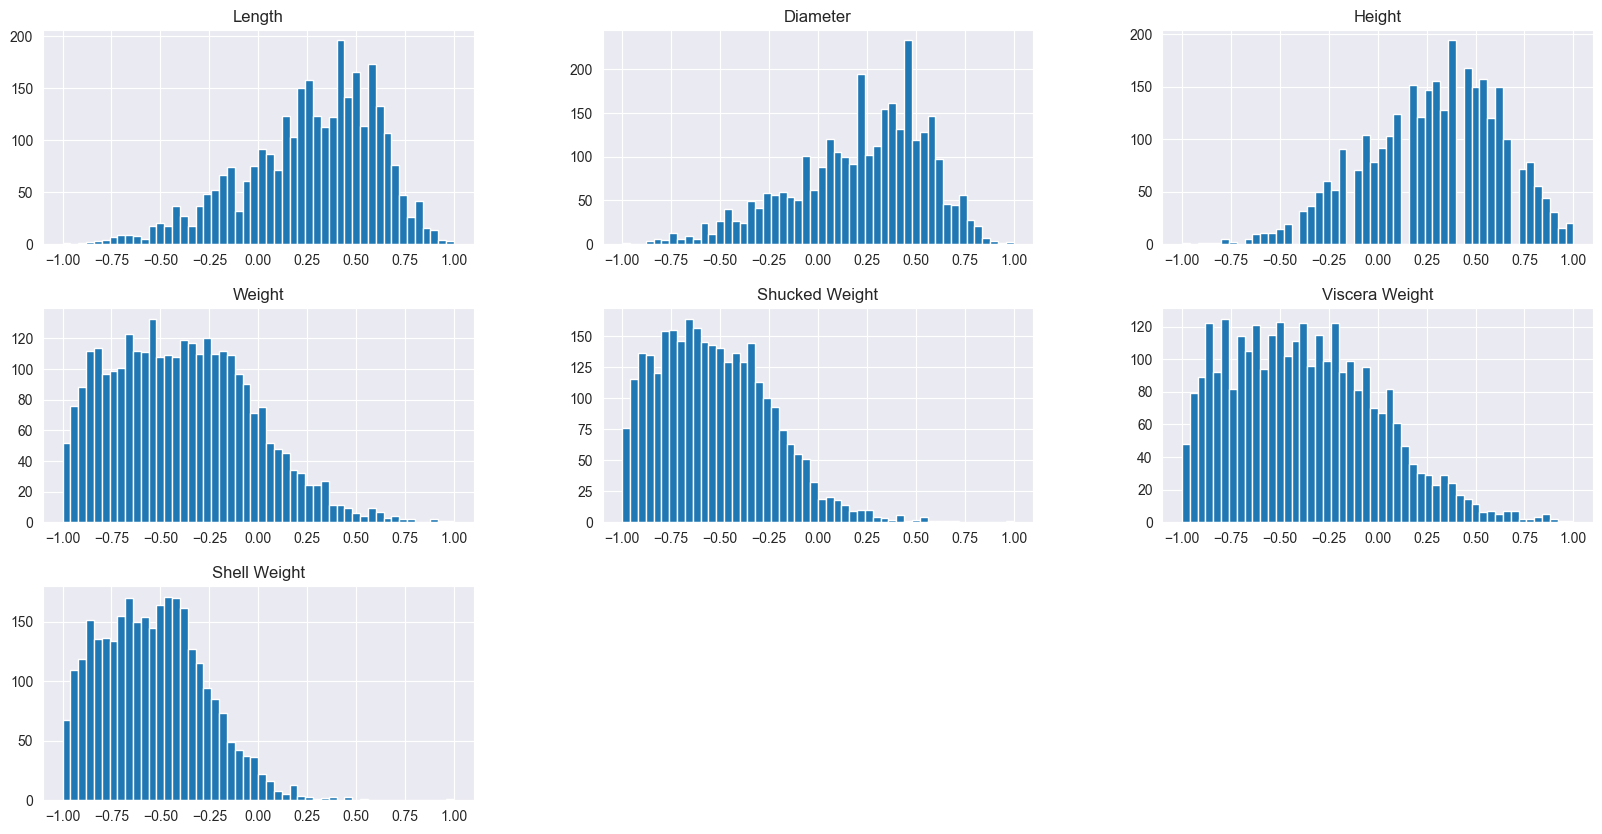

In [7]:
%%time
# Plotting the distribution of the features
X_train.hist(figsize=(20, 10), bins=50)
plt.title('After Normalization')


### Show Correlation Matrix

To see how the features are correlated with each other.


CPU times: total: 62.5 ms
Wall time: 88.5 ms


<Axes: title={'center': 'Correlation Graph'}>

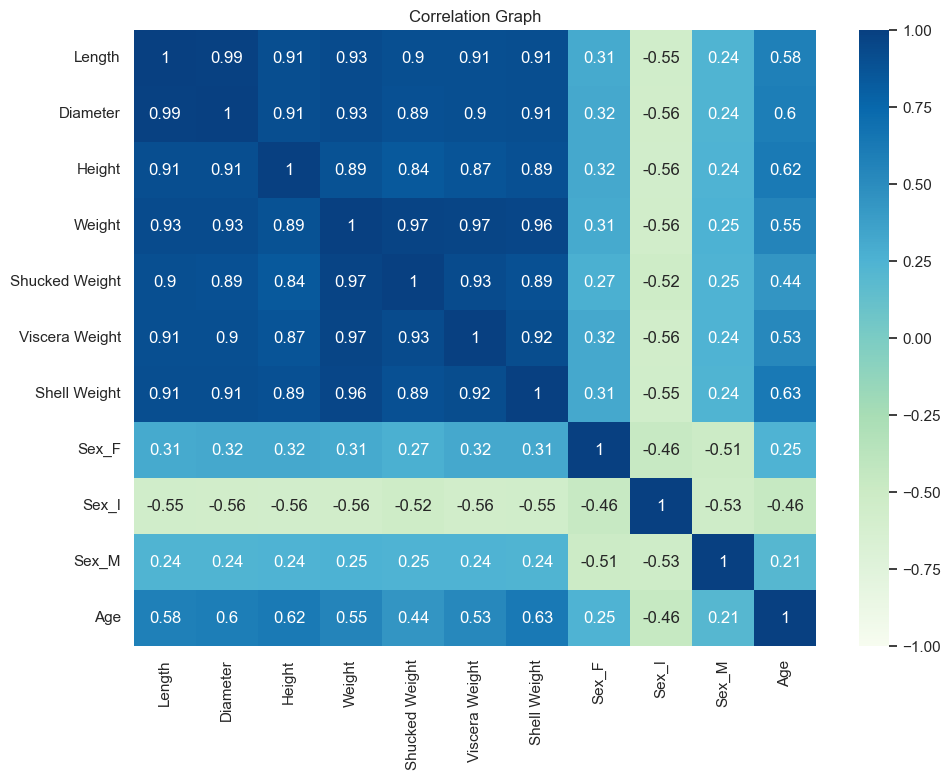

In [8]:
%%time
sns.set()
plt.figure(figsize = (11,8))
plt.title('Correlation Graph')
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.heatmap(crabs.corr(), vmin=-1, vmax=1, annot=True, cmap='GnBu')


### Feature Significance

Remove features with low variance. These features are likely to be less important for the model.


In [9]:
%%time
# use VarianceThreshold?


CPU times: total: 0 ns
Wall time: 0 ns


### Data Augmentation

Crabs are complex creatures. Let's engineer some features to help our model find the best crabs for harvest.

We'll need to use domain knowledge to extract more features from our dataset's column.

![This kills the crab.](https://i.kym-cdn.com/photos/images/newsfeed/000/112/843/killcrab.jpg)

For example, we can find the edible weight of the crab by subtracting the viscera weight from the shucked weight.  
However, we need to be careful not to overfit the model by adding coliinear features.


In [10]:
%%time
def data_augmentation(df:pd.DataFrame) -> pd.DataFrame:
    """Add new features to the DataFrame.

    Driven by domain knowledge.

    :param df: The data.
    :return: The data with new features.
    """
    # add new features by combining existing features
    df['Edible Weight'] = df['Shucked Weight'] - df['Viscera Weight']
    return df


CPU times: total: 0 ns
Wall time: 0 ns


## Feature Selection

Selecting only the most important features. We'll use **Recursive Feature Elimination** (RFE).


In [11]:
%%time
# implement RFE from scratch

def rfe(X:pd.DataFrame, y:pd.Series, n_features:int) -> pd.DataFrame:
    """Select the most important features using Recursive Feature Elimination.

    :param X: The features.
    :param y: The target.
    :param n_features: The number of features to select.
    :return: The selected features.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.feature_selection import RFE

    # create the RFE model and select n features
    model = LinearRegression()
    rfe = RFE(model, n_features)
    fit = rfe.fit(X, y)

    # get the selected features
    selected = fit.support_
    return X.loc[:, selected]


CPU times: total: 0 ns
Wall time: 0 ns


## Save the Data

So we can pick this back up on the [next step](../3-evaluation/evaluation.ipynb).


In [12]:
%%time
crabs.to_feather(NEXT_CACHE_FILE)


CPU times: total: 0 ns
Wall time: 3.99 ms


## Onwards to Final Evaluation

See the [next section](../3-evaluation/evaluation.ipynb) for the final evaluation.

[`<html link>`](https://nbviewer.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/3-evaluation/evaluation.ipynb) for model evaluation.
